# Solución Tarea 2

#### Estudiantes:
- Nicolás Prieto Escobar
- Pablo A. Saldarriaga Aristizabal

### Problema:

Se cuenta con información georeferenciada de accidentes que han ocurrido en diferentes barrios en la ciudad de Medellín durante el año 2017, se tienen alrededor de 312 barrios diferentes en el conjunto de datos. El objetivo para este caso de estudio, es hora a hora tratar de predecir si en un barrio determinado ocurrirá o no un accidente en base a las condiciones climáticas actuales.

### Importación de paquetes para ejecutar este Notebook

In [1]:
%matplotlib notebook

In [2]:
import os
import random
import sqlite3
import numpy as np
import pandas as pd
import datetime as dt
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

In [3]:
from mlxtend.evaluate import PredefinedHoldoutSplit
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [4]:
### Silencio warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### CORRECCION: Paquetes nuevos

Incluiremos una métrica adicional a considerar, ya que el problema de desbalanceo de clases para el caso de la accidentalidad de Medellín es dificil en términos de modelamiento de la predicción de la ocurrencia de un accidente. Esta métrica será el Recall

In [5]:
### CORRECCION
from sklearn.metrics import recall_score

Fijamos la semilla aleatoria para garantizar replicabilidad

In [6]:
SEED = 1  # use this constant seed everywhere
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)  # `python` built-in pseudo-random generator
np.random.seed(SEED)  # numpy pseudo-random generator

#### Datos para la tarea
Para utilizar técnicas de ingeniería de características, en esta tarea consideramos la información del barrio "La Candelaria" en el periodo de tiempo Junio 1 a Diciembre 31 de 2017. Las variables climáticas disponibles en el conjunto de datos son:

- icon
- precipIntensity
- precipProbability
- temperature
- apparentTemperature
- dewPoint
- humidity
- windSpeed
- cloudCover
- uvIndex
- visibility

In [7]:
### Lectura del dataset a usar (se usa un subconjunto del dataset por motivos de tiempo)
data = pd.read_csv('data/data_tarea1.csv',sep =',')
data['TW'] = pd.to_datetime(data['TW'])

Agregamos variables relacionadas a la fecha, como lo son la hora en la que occure el accidente y el día de la semana

In [8]:
### Agregar otras features
data['hora'] = data['TW'].dt.hour
data['dia_sem'] = data['TW'].dt.dayofweek

data= pd.get_dummies(data, columns=['hora'])
data= pd.get_dummies(data, columns=['icon'])
data= pd.get_dummies(data, columns=['dia_sem'])

Adicional a las variables que se crearon, realizaremos un aumento del conjunto de datos en base a uno de los estadisticos que da información distribucional de las variables, la cual es la media. Las variables climaticas que estamos considerando, son series de tiempo para las cuales, se les verificó previamente su estacionariedad, así que a forma de obtener una mayor información de cada una de la series, agregamos para cada una, una media móvil de las últimas 5 horas

In [9]:
freq = '5H'
variables = ['temperature','precipIntensity','apparentTemperature','dewPoint','humidity','windSpeed','cloudCover','visibility']

In [10]:
data_aux = data.copy()
data_aux.index = data_aux.TW
data_aux = data_aux.sort_index()
data_aux = data_aux.drop(columns = 'TW')
resample_data = data_aux[variables].rolling(freq, closed = 'left').mean()

In [11]:
data_pivot = data_aux.pivot_table(values=variables, index='TW',columns='BARRIO', aggfunc=sum)
data_mean = data_pivot.rolling(freq, closed = 'left').mean().stack().reset_index(drop = False)

col_means = [*data_mean.columns[:2]]
for col in data_mean.columns[2:]:
    col_means.append(col + '_mean')
    
data_mean.columns = col_means

In [12]:
data = data.merge(data_mean, how = 'left', on = ['TW','BARRIO'])
data = data.dropna().reset_index(drop = True)

In [13]:
### Seleccionar variable entrada y salida 
X = data.drop("Accidente", 1).reset_index(drop=True)       # feature matrix 
y = data['Accidente'].reset_index(drop=True)               # target feature
X = X[X.columns[2:]]

In [14]:
X.columns

Index(['precipIntensity', 'precipProbability', 'temperature',
       'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'uvIndex', 'visibility', 'hora_0', 'hora_1', 'hora_2',
       'hora_3', 'hora_4', 'hora_5', 'hora_6', 'hora_7', 'hora_8', 'hora_9',
       'hora_10', 'hora_11', 'hora_12', 'hora_13', 'hora_14', 'hora_15',
       'hora_16', 'hora_17', 'hora_18', 'hora_19', 'hora_20', 'hora_21',
       'hora_22', 'hora_23', 'icon_clear-day', 'icon_clear-night',
       'icon_cloudy', 'icon_fog', 'icon_partly-cloudy-day',
       'icon_partly-cloudy-night', 'icon_rain', 'dia_sem_0', 'dia_sem_1',
       'dia_sem_2', 'dia_sem_3', 'dia_sem_4', 'dia_sem_5', 'dia_sem_6',
       'apparentTemperature_mean', 'cloudCover_mean', 'dewPoint_mean',
       'humidity_mean', 'precipIntensity_mean', 'temperature_mean',
       'visibility_mean', 'windSpeed_mean'],
      dtype='object')

In [15]:
X.shape

(5112, 56)

In [16]:
y.sum()

529.0

Se realiza la partición del conjunto de datos en 3 conjuntos:
- Train (60%)
- Validation (20%)
- Test (20%)

In [17]:
### Partir en train y test los datos
X_train, X_val1, y_train, y_val1 = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.40,  random_state = 42)

In [18]:
X_val, X_test, y_val, y_test = train_test_split(X_val1, y_val1,
                                                    stratify=y_val1, 
                                                    test_size=0.5,  random_state = 42)

In [19]:
X_train.shape

(3067, 56)

In [20]:
X_test.shape

(1023, 56)

In [21]:
y_test.sum()

106.0

In [22]:
X_val.shape

(1022, 56)

In [23]:
y_val.sum()

106.0

Debido a que los datos se encuentran muy desbalanceados, realizamos un undersampling de forma tal que obtengamos una proporcion de 70%-30% entre la cantidad de 1's y 0's. Dicha proporción se determinó al realizar un análisis sobre el porcentaje de undersampling que se debe usar, esto se encuentra en el notebook "Undersampling" en la carpeta "notebooks auxiliares"

In [24]:
### Hacer undersampling (los datos estan desbalanceados)
tra_0 = int(len(y_train) - y_train.sum())
tra_1 = int(y_train.sum())

prop_deseada_under = 0.3
mul_updown = (tra_0 * prop_deseada_under - tra_1 * (1 - prop_deseada_under)) / (tra_0 * prop_deseada_under)   
fac_1 = int(tra_0 * (1 - mul_updown))

ratio_u = {0 : fac_1, 1 : tra_1}
rus = RandomUnderSampler(sampling_strategy = ratio_u, random_state=42)
X_train, y_train = rus.fit_sample(X_train, y_train)

X_tr = X_train
y_tr = y_train

In [25]:
X_tr.shape

(1056, 56)

In [26]:
y_tr.sum()

317.0

El tipo de método que usamos para la parte de selección de variables, es un método de envoltura, por lo que definiremos un modelo basado en árboles que nos permita tener una idea de que tan bien se ajusta inicialmente los datos a un modelo de clasificación.

Por otro lado, estamos considerando un método de forward selection implementado desde cero, al igual que forward selection y backward selection que tiene el paquete mlxextend. La métrica que utilizaremos para la selección de variables a medida que se hagan la iteración de los modelos, es la relacionada con la Curva ROC-AUC.

Otras métricas que utilizamos para evaluar el desempeño del modelo en el conjunto de prueba son:
- F1 Score
- Balanced Accuracy

In [27]:
### Este es el modelo que sera explotado por los metodos de envoltura
clf = ExtraTreesClassifier(n_estimators=70, random_state = 42)

In [28]:
### CORRECCION: Definimos un umbral para realizar las predicciones
threshold = 0.2

### Forward Selection - Método programado

In [29]:
print('\nSeleccionando variables con forward selection propio...')
### la metrica que usaremos es roc_auc
metrica_usada = roc_auc_score

### Ahora si, el codigo para seleccionar variables forward
elegids = []
metri_it = []
vars_it = []
features = list(X.columns)
eleg = []

### Itero por todas las columnas
for va in range(len(features)):
    ### Restan por agregar
    restantes = list(set(features) - set(eleg))
    ### Reinicio la metrica
    best_metri = 0
    ### En cada ciclo, miro todas las columnas restantes
    for restan in restantes:    
        ### Agrego temporalmente variable
        eleg_temp = eleg.copy()
        eleg_temp.append(restan)    
        ### Estimo el modelo con esas variables
        clf.fit(X_tr[eleg_temp], y_tr)    
        ### Predigo para test
        predi = clf.predict(X_val[eleg_temp])
        scori = clf.predict_proba(X_val[eleg_temp])
        ### Evaluo metrica
        metri = metrica_usada(y_val, scori[:,1])    
        ### Si mejoro a la anterior + un epsilon, actualizo
        if metri > best_metri + 0.000001:
            best_eleg = eleg_temp.copy()
            best_metri = metri
    
    ### Agrego la mejor variable de esta iteracion
    eleg = best_eleg.copy()
    ### Guardo las mejores metricas de cada iteracion
    metri_it.append(best_metri.copy())
    vars_it.append(eleg.copy())
    
print('\nMejores variables con forward selection metodo propio :')
print(vars_it[np.argmax(metri_it)])


Seleccionando variables con forward selection propio...

Mejores variables con forward selection metodo propio :
['windSpeed', 'dia_sem_6', 'hora_7', 'hora_3', 'hora_0', 'hora_1', 'hora_2', 'icon_fog', 'hora_22', 'hora_8', 'hora_21', 'hora_4', 'hora_5', 'hora_9', 'hora_15', 'humidity', 'precipIntensity_mean', 'dia_sem_5', 'hora_19', 'hora_12', 'hora_16', 'icon_clear-day', 'uvIndex', 'hora_20', 'icon_cloudy', 'precipIntensity', 'hora_23', 'hora_10', 'humidity_mean', 'cloudCover_mean', 'hora_18']


Para el metodo forward selection programado, podemos ver la evoluciona la metrica ROC-AUC respecto a la cantidad de características que tiene el modelo

<IPython.core.display.Javascript object>


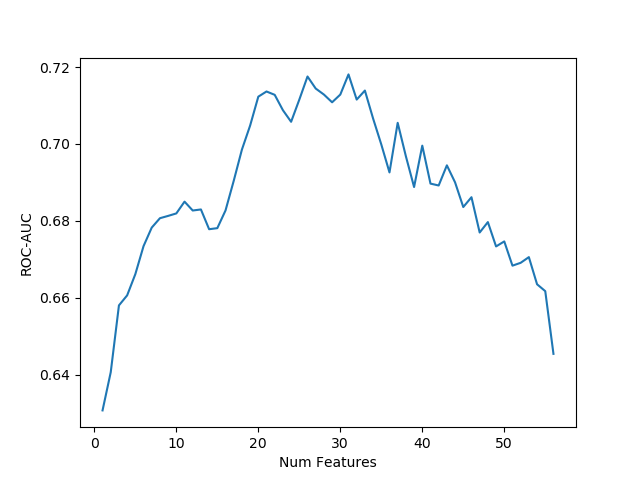

Text(0, 0.5, 'ROC-AUC')

In [30]:
plt.figure('ROC vs Num variables')
plt.plot(range(1,len(metri_it)+1),metri_it)
plt.xlabel('Num Features')
plt.ylabel('ROC-AUC')

Una vez obtenido el mejor conjunto de variables para el modelo, lo entrenamos con las variables seleccionadas y utilizamos el modelo en el conjunto de prueba

In [31]:
clf.fit(X_train[vars_it[np.argmax(metri_it)]],y_train)
preds = clf.predict(X_test[vars_it[np.argmax(metri_it)]])
score = clf.predict_proba(X_test[vars_it[np.argmax(metri_it)]])

#######################
### CORRECCION: Variablos el umbral para mostrar los resultados
preds = (score[:,1] >= threshold).astype(int)
#######################

print(f'ROC:{roc_auc_score(y_test,score[:,1])}')
print(f'Fscore:{f1_score(y_test,preds)}')
print(f'Balanced accuracy:{balanced_accuracy_score(y_test,preds)}')

### CORRECCION
print('***'*20)
print('CORRECCION: Metricas Adicionales')
print(f'Recall:{recall_score(y_test,preds)}')

ROC:0.6947696549453715
Fscore:0.2813455657492355
Balanced accuracy:0.6853254048270612
************************************************************
CORRECCION: Metricas Adicionales
Recall:0.8679245283018868


### Forward Selection - Método de mlxtend

In [32]:
### Ahora, evaluemos forward selection Con mlxtend
print('\nSeleccionando variables con forward selection de mlxtend...')

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features='best',
           forward=True,
           floating=False,
           verbose=0,
           scoring='roc_auc',
           cv=2)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)

# Which features?
feat_cols = list(sfs1.k_feature_idx_)
print('\nMejores variables con forward selection de mlxtend :')
print(list(X.columns[feat_cols]))

### Evolucion a traves del tiempo
evol_1 = sfs1.subsets_


Seleccionando variables con forward selection de mlxtend...

Mejores variables con forward selection de mlxtend :
['cloudCover', 'hora_0', 'hora_1', 'hora_3', 'hora_4', 'hora_11', 'hora_16', 'hora_20', 'hora_21', 'hora_22', 'icon_cloudy', 'icon_partly-cloudy-day', 'dia_sem_0', 'dia_sem_6']


In [33]:
scores_forward = []
for key in evol_1.keys():
    scores_forward.append(np.mean(evol_1[key]['cv_scores']))

Para el metodo forward selection de la libreria mlxtend, podemos ver la evoluciona la metrica ROC-AUC respecto a la cantidad de características que tiene el modelo

<IPython.core.display.Javascript object>


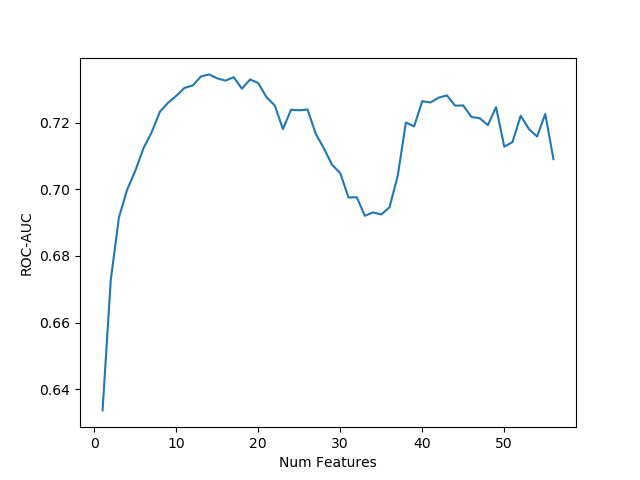

Text(0, 0.5, 'ROC-AUC')

In [34]:
plt.figure('ROC vs Num Features Forward Selection mlxtend')
plt.plot(range(1,len(scores_forward)+1),scores_forward)
plt.xlabel('Num Features')
plt.ylabel('ROC-AUC')

In [35]:
feat_cols 

[7, 10, 11, 13, 14, 21, 26, 30, 31, 32, 36, 38, 41, 47]

Una vez obtenido el mejor conjunto de varibles para el modelo, lo entrenamos con las variables seleccionadas y utilizamos el modelo en el conjunto de prueba

In [36]:
clf.fit(X_train[X.columns[feat_cols]],y_train)
preds = clf.predict(X_test[X.columns[feat_cols]])
score = clf.predict_proba(X_test[X.columns[feat_cols]])

#######################
### CORRECCION: Variablos el umbral para mostrar los resultados
preds = (score[:,1] >= threshold).astype(int)
#######################

print(f'ROC:{roc_auc_score(y_test,score[:,1])}')
print(f'Fscore:{f1_score(y_test,preds)}')
print(f'Balanced accuracy:{balanced_accuracy_score(y_test,preds)}')

### CORRECCION
print('***'*20)
print('CORRECCION: Metricas Adicionales')
print(f'Recall:{recall_score(y_test,preds)}')

ROC:0.6681086808913397
Fscore:0.2559241706161137
Balanced accuracy:0.6388911750787021
************************************************************
CORRECCION: Metricas Adicionales
Recall:0.7641509433962265


### Backward Selection - Método de mlxtend

In [37]:
### Por ultimo, evaluemos forward selection Con mlxtend
print('\nSeleccionando variables con backward selection de mlxtend...')
# Build step forward feature selection
sfs2 = sfs(clf,
           k_features='best',
           forward=False,
           floating=False,
           verbose=0,
           scoring='roc_auc',
           cv=2)

# Perform SFFS
sfs2 = sfs2.fit(X_train.values, y_train.values)

# Which features?
feat_cols = list(sfs2.k_feature_idx_)
print('\nMejores variables con backward selection de mlxtend :')
print(list(X.columns[feat_cols]))


### Print
### Evolucion a traves del tiempo
evol_2 = sfs2.subsets_


Seleccionando variables con backward selection de mlxtend...

Mejores variables con backward selection de mlxtend :
['dewPoint', 'cloudCover', 'visibility', 'hora_0', 'hora_1', 'hora_8', 'hora_11', 'hora_12', 'hora_14', 'hora_17', 'hora_18', 'hora_21', 'hora_22', 'hora_23', 'icon_partly-cloudy-night', 'dia_sem_0', 'dia_sem_3', 'dia_sem_5', 'dia_sem_6', 'apparentTemperature_mean', 'visibility_mean']


In [38]:
scores_backward = []
idx = []
for key in evol_2.keys():
    idx.append(key)
    scores_backward.append(np.mean(evol_2[key]['cv_scores']))

Para el metodo backward selection de la libreria mlxtend, podemos ver la evoluciona la metrica ROC-AUC respecto a la cantidad de características que tiene el modelo

<IPython.core.display.Javascript object>


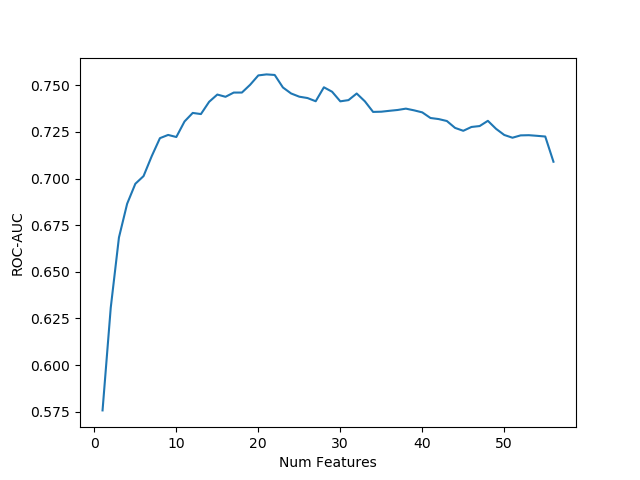

Text(0, 0.5, 'ROC-AUC')

In [39]:
plt.figure('ROC vs Num Features Backward Selection mlxtend')
plt.plot(idx, scores_backward)
plt.xlabel('Num Features')
plt.ylabel('ROC-AUC')

Una vez obtenido el mejor conjunto de varibles para el modelo, lo entrenamos con las variables seleccionadas y utilizamos el modelo en el conjunto de prueba

In [40]:
clf.fit(X_train[X.columns[feat_cols]],y_train)
preds = clf.predict(X_test[X.columns[feat_cols]])
score = clf.predict_proba(X_test[X.columns[feat_cols]])

#######################
### CORRECCION: Variablos el umbral para mostrar los resultados
preds = (score[:,1] >= threshold).astype(int)
#######################

print(f'ROC:{roc_auc_score(y_test,score[:,1])}')
print(f'Fscore:{f1_score(y_test,preds)}')
print(f'Balanced accuracy:{balanced_accuracy_score(y_test,preds)}')

### CORRECCION
print('***'*20)
print('CORRECCION: Metricas Adicionales')
print(f'Recall:{recall_score(y_test,preds)}')

ROC:0.6936842863315569
Fscore:0.2694136291600634
Balanced accuracy:0.6610306372296866
************************************************************
CORRECCION: Metricas Adicionales
Recall:0.8018867924528302


De este caso de estudio, podemos ver que el rendimiento que tiene solo un subconjunto de variables es mejor para los 3 metodos en comparación a utilizar la totalidad de variables disponibles, igualmente vemos que el desempeño de los 3 metodos en el conjunto de test es muy parecido entre ellos, además de obtener resultados prometedores